In [62]:
import numpy as np
import pandas as pd

import os
import numpy as np
os.environ['CMDSTAN'] = '/Users/carlo/.cmdstan/cmdstan-2.30.1'

import cmdstanpy

from cmdstanpy import cmdstan_path, CmdStanModel

import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import math as m


### 1) Import of data

In [2]:
tfidf=pd.read_csv("tfidf_red_90.csv")

In [3]:
tfidf.head()

,bore,disappoint,bad,wast,instead,easi,highli,excel,lack,poorli,...,comprehens,rambl,suspect,explor,guy,honestli,invit,extraordinari,outstand,type_text
0,0.0,0.0,0.000000,0.26874,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.000000,0.26874,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.176857,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [4]:
df=tfidf

Covariates:

In [5]:
x=df.drop(labels=["type_text"] , axis=1)
names=x.columns
x.head()

,bore,disappoint,bad,wast,instead,easi,highli,excel,lack,poorli,...,fantast,comprehens,rambl,suspect,explor,guy,honestli,invit,extraordinari,outstand
0,0.0,0.0,0.000000,0.26874,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.26874,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.176857,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Responses:

In [7]:

y1=[0 for i in range (1000)]
y2=[1 for i in range(1000)]
y=y1+y2
y=np.array(y)

In [8]:
y

array([0, 0, 0, ..., 1, 1, 1])

###### Covariates in a Dataframe "x"
###### Responses in a numpy array "y"

### 2) Normalisation of covariates

In [9]:
from sklearn import preprocessing

In [10]:
x= preprocessing.scale(x)


In [11]:
x=pd.DataFrame(x)
x.columns=names


##### 2.1 Splitting trainin-test

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 60/2000, random_state=0)

In [13]:
x_train=np.array(x_train)
y_train=np.array(y_train)
x_test=np.array(x_test)
y_test=np.array(y_test)


### 3) Spike and Slab prior - Hard shrinkage feature selection

Spike and Slab

In [14]:
 stan_code = """
data {
        int<lower=1> N;
        int<lower=1> p;
        int<lower=0,upper=1> y[N];
        matrix[N,p] x;
        
        real<lower=0> var_spike;
        real<lower=0> var_slab;
        
        
    }
        
     

    
    
    parameters {
       
        vector[p] beta;

        
    }
    
   

   transformed parameters{

     real <lower=0, upper=1> mu[N];
     
     for(i in 1:N)
     {
     
     mu[i]= inv_logit(x[i,:]*beta);
     }
}

    
    model {
        
        y ~ bernoulli(mu);
        
           
        target += log_mix(0.5, 
                         normal_lpdf(beta | 0, var_slab),
                         normal_lpdf(beta | 0, var_spike));
        
       
    }
    
    
     
"""

        
        


    
stan_file_logistic_regression = "./logistic_regression_lib.stan"
 
with open(stan_file_logistic_regression, "w") as f:   
        print(stan_code, file=f)
stan_model = CmdStanModel(stan_file=stan_file_logistic_regression   ,   cpp_options={"STAN_THREADS": True})




16:15:21 - cmdstanpy - INFO - compiling stan file C:\Users\carlo\Bayesian statistics project\logistic_regression_lib.stan to exe file C:\Users\carlo\Bayesian statistics project\logistic_regression_lib.exe
16:15:40 - cmdstanpy - INFO - compiled model executable: C:\Users\carlo\Bayesian statistics project\logistic_regression_lib.exe
16:15:40 - cmdstanpy - WARNING - Stan compiler has produced 2 warnings:
16:15:40 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/carlo/BAYESI~1/logistic_regression_lib.hpp C:/Users/carlo/BAYESI~1/logistic_regression_lib.stan
Warning in 'C:/Users/carlo/BAYESI~1/logistic_regression_lib.stan', line 5, column 7: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/Users/carlo/BAYESI~1/logistic_regression_lib.st

###### Logistic Regression model  (to evaluate the result of the feature selection)

In [15]:
Logistic_regression_model_1_code = """
data{
  
   int<lower=0> N;
   
   int<lower=0> p;

   
   int y[N];
   
   matrix[N,p] x;
   
}



parameters {

    vector[p] beta;
    
}

transformed parameters{

     real <lower=0, upper=1> mu[N];
     
     for(i in 1:N)
     {
     
     mu[i]= inv_logit(x[i,:]*beta);
     }
}

model{


    y~ bernoulli(mu);
    
    beta[1]~cauchy(0,10);
    
    for (j in 2:p){

    beta~cauchy(0,2.5);
    }

}

generated quantities  {
      vector[N] log_lik;
      for (j in 1:N) {
            log_lik[j] = bernoulli_lpmf(y[j] | mu[j]);
      }
     
}


"""





stan_file_logistic_1 = "./logistic_regression_model_1.stan"

with open(stan_file_logistic_1, "w") as f:   # write the normal code into a file named ./multi_normal.stan
    print(Logistic_regression_model_1_code, file=f)

stan_model1 = CmdStanModel(stan_file=stan_file_logistic_1,   cpp_options={"STAN_THREADS": True})



16:15:40 - cmdstanpy - INFO - compiling stan file C:\Users\carlo\Bayesian statistics project\logistic_regression_model_1.stan to exe file C:\Users\carlo\Bayesian statistics project\logistic_regression_model_1.exe
16:15:58 - cmdstanpy - INFO - compiled model executable: C:\Users\carlo\Bayesian statistics project\logistic_regression_model_1.exe
16:15:58 - cmdstanpy - WARNING - Stan compiler has produced 2 warnings:
16:15:58 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/carlo/BAYESI~1/logistic_regression_model_1.hpp C:/Users/carlo/BAYESI~1/logistic_regression_model_1.stan
Warning in 'C:/Users/carlo/BAYESI~1/logistic_regression_model_1.stan', line 9, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/Users/carlo/BAYESI~1/lo

### 4) Spike and Slab computation

In [16]:
N=x_train.shape[0]

p=x_train.shape[1]


In [17]:
dat = {
    
    "N": N,
    "p": p,
    "y": y_train,
    "x": x_train,
    "var_spike": 0.5,
    "var_slab":35 ,
  
}

stan_fit1 = stan_model.sample(data=dat, chains=4, 
                             parallel_chains=4 ,inits=0  , threads_per_chain=3)
cmdstanpy_data1 = az.from_cmdstanpy(stan_fit1)

16:16:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:17:04 - cmdstanpy - INFO - CmdStan done processing.


In [48]:
x_train= preprocessing.scale(x_train)/2
x_test= preprocessing.scale(x_test)/2
x_train

array([[-0.10476786, -0.1308661 , -0.11921387, ..., -0.03340381,
        -0.03434804, -0.03254028],
       [-0.10476786, -0.1308661 , -0.11921387, ..., -0.03340381,
        -0.03434804, -0.03254028],
       [-0.10476786, -0.1308661 , -0.11921387, ..., -0.03340381,
        -0.03434804, -0.03254028],
       ...,
       [-0.10476786, -0.1308661 , -0.11921387, ..., -0.03340381,
        -0.03434804, -0.03254028],
       [-0.10476786, -0.1308661 , -0.11921387, ..., -0.03340381,
        -0.03434804, -0.03254028],
       [-0.10476786, -0.1308661 , -0.11921387, ..., -0.03340381,
        -0.03434804, -0.03254028]])

In [52]:
x_tr=pd.DataFrame(x_train)
x_tr.columns=names

x_ts=pd.DataFrame(x_test)
x_ts.columns=names
x_tr.describe()

,bore,disappoint,bad,wast,instead,easi,highli,excel,lack,poorli,...,fantast,comprehens,rambl,suspect,explor,guy,honestli,invit,extraordinari,outstand
count,1.940000e+03,1.940000e+03,1.940000e+03,1.940000e+03,1.940000e+03,1.940000e+03,1.940000e+03,1.940000e+03,1.940000e+03,1.940000e+03,...,1.940000e+03,1.940000e+03,1.940000e+03,1.940000e+03,1.940000e+03,1.940000e+03,1.940000e+03,1.940000e+03,1.940000e+03,1.940000e+03
mean,-8.240831e-18,1.831296e-18,-3.204767e-17,1.007213e-17,-9.614302e-18,4.028851e-17,2.746944e-18,-2.563814e-17,1.991534e-17,-7.096271e-18,...,1.098777e-17,3.662591e-17,4.578239e-18,2.392130e-17,2.105990e-17,4.532457e-17,2.472249e-17,2.380684e-17,-1.190342e-17,-3.662591e-18
std,5.001289e-01,5.001289e-01,5.001289e-01,5.001289e-01,5.001289e-01,5.001289e-01,5.001289e-01,5.001289e-01,5.001289e-01,5.001289e-01,...,5.001289e-01,5.001289e-01,5.001289e-01,5.001289e-01,5.001289e-01,5.001289e-01,5.001289e-01,5.001289e-01,5.001289e-01,5.001289e-01
min,-1.047679e-01,-1.308661e-01,-1.192139e-01,-9.354543e-02,-1.204061e-01,-1.082349e-01,-1.085075e-01,-9.945743e-02,-1.031208e-01,-6.134154e-02,...,-5.952827e-02,-5.172537e-02,-4.239099e-02,-5.669371e-02,-6.966240e-02,-8.232517e-02,-4.196899e-02,-3.340381e-02,-3.434804e-02,-3.254028e-02
25%,-1.047679e-01,-1.308661e-01,-1.192139e-01,-9.354543e-02,-1.204061e-01,-1.082349e-01,-1.085075e-01,-9.945743e-02,-1.031208e-01,-6.134154e-02,...,-5.952827e-02,-5.172537e-02,-4.239099e-02,-5.669371e-02,-6.966240e-02,-8.232517e-02,-4.196899e-02,-3.340381e-02,-3.434804e-02,-3.254028e-02
50%,-1.047679e-01,-1.308661e-01,-1.192139e-01,-9.354543e-02,-1.204061e-01,-1.082349e-01,-1.085075e-01,-9.945743e-02,-1.031208e-01,-6.134154e-02,...,-5.952827e-02,-5.172537e-02,-4.239099e-02,-5.669371e-02,-6.966240e-02,-8.232517e-02,-4.196899e-02,-3.340381e-02,-3.434804e-02,-3.254028e-02
75%,-1.047679e-01,-1.308661e-01,-1.192139e-01,-9.354543e-02,-1.204061e-01,-1.082349e-01,-1.085075e-01,-9.945743e-02,-1.031208e-01,-6.134154e-02,...,-5.952827e-02,-5.172537e-02,-4.239099e-02,-5.669371e-02,-6.966240e-02,-8.232517e-02,-4.196899e-02,-3.340381e-02,-3.434804e-02,-3.254028e-02
max,4.849419e+00,5.252686e+00,6.594061e+00,8.035851e+00,5.799133e+00,5.229716e+00,8.507528e+00,6.106471e+00,7.671304e+00,7.952520e+00,...,1.022716e+01,1.066683e+01,9.964144e+00,9.804616e+00,9.380430e+00,8.442329e+00,8.823645e+00,1.241999e+01,1.152478e+01,1.126636e+01


### 5) Assess the optimal number of features 

In [54]:


def compute_mu(betaa,xx):
    
    mu=[]
    
    for i in range(len(xx)):
        
        muu=m.e**(np.dot(xx[i].T,betaa))/(1+m.e**(np.dot(xx[i].T,betaa)))
        
        mu.append(muu)
        
    return mu


def predictions(mu_hat, threshold):
    
    L= len(mu_hat)
    
    out=np.zeros(L)
    
    
    for i in range(L):
        
        if mu_hat[i]>threshold:
            out[i]+=1
            
    return out



    

##### Explore several HDI and for each of them computes the WAIC on the training_set and the Accuracy on the test_set

In [55]:
num_of_feat=[]

probabilities=[0.6,0.7,0.8,0.9,0.95,0.975]


waic=[]

acc=[]


for prob in probabilities:
    BB=az.hdi(cmdstanpy_data1.posterior,prob)
    
    keep=[]

    for i in range(90):
   
        if(BB.beta[i][0]<0 and BB.beta[i][1]>0 ):
            {}
        else:
            keep.append(i)
            
    X=x_tr[names[keep]]
    X.insert(0,"1",[1 for i in range(1940)],True)
    
    X_ts=x_ts[names[keep]]
    X_ts.insert(0,"1",[1 for i in range(60)],True)
   
    
    X=np.array(X)
    X_ts=np.array(X_ts)
    
    N=X.shape[0]
    
    num_of_feat.append(len(keep))

    p=len(keep)+1

    y=y
    
    dat = {
    
    "N": N,
    "p": p,
    "y": y_train,
    "x": X,
     }

    stan_fit2 = stan_model1.sample(data=dat, chains=2 ,inits=0, parallel_chains=2)
    cmdstanpy_data2 = az.from_cmdstanpy(stan_fit2)
    
    waic.append(az.waic(cmdstanpy_data2, var_name="log_lik")[0])
    
    beta_chains1=cmdstanpy_data2.posterior.beta
    
    beta_hat1=beta_chains1.mean(dim=["draw","chain"])
    
    posterior_mu1=compute_mu(beta_hat1,X_ts)
    
    pred1=predictions(posterior_mu1,0.5)
    
    confusion_matrix1 = pd.crosstab(y_test, pred1)

    
    acc.append((confusion_matrix1[0][0]+confusion_matrix1[1][1])/60)
    
    
    

    


17:14:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:16:06 - cmdstanpy - INFO - CmdStan done processing.


C:\Users\carlo\anaconda3\envs\stan_env\lib\site-packages\arviz\stats\stats.py:1663: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
17:16:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:17:23 - cmdstanpy - INFO - CmdStan done processing.


C:\Users\carlo\anaconda3\envs\stan_env\lib\site-packages\arviz\stats\stats.py:1663: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
17:17:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:18:41 - cmdstanpy - INFO - CmdStan done processing.


C:\Users\carlo\anaconda3\envs\stan_env\lib\site-packages\arviz\stats\stats.py:1663: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
17:18:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:19:52 - cmdstanpy - INFO - CmdStan done processing.


C:\Users\carlo\anaconda3\envs\stan_env\lib\site-packages\arviz\stats\stats.py:1663: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
17:20:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:21:13 - cmdstanpy - INFO - CmdStan done processing.


C:\Users\carlo\anaconda3\envs\stan_env\lib\site-packages\arviz\stats\stats.py:1663: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
17:21:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:22:09 - cmdstanpy - INFO - CmdStan done processing.


C:\Users\carlo\anaconda3\envs\stan_env\lib\site-packages\arviz\stats\stats.py:1663: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


In [56]:
print(num_of_feat)
print(waic)
print(acc)


[85, 80, 77, 71, 57, 53]
[-923.8915298141771, -921.3917191411738, -921.0704034259101, -921.721780079285, -935.4887789156992, -942.5892269636563]
[0.75, 0.75, 0.75, 0.7666666666666667, 0.7666666666666667, 0.75]


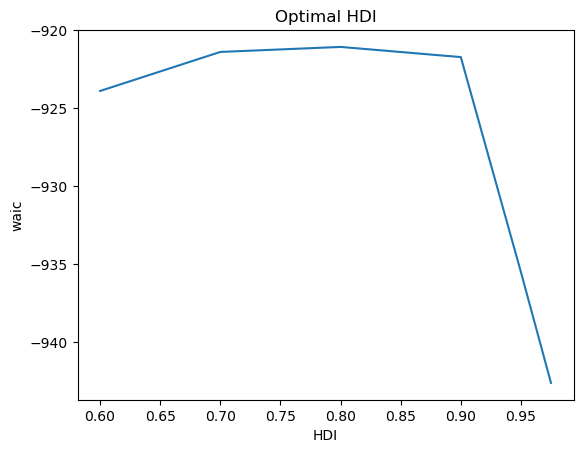

In [57]:
import matplotlib.pyplot 
  
# plotting the points 
matplotlib.pyplot.plot(probabilities, waic)
  
# naming the x axis
matplotlib.pyplot.xlabel('HDI')
# naming the y axis
matplotlib.pyplot.ylabel('waic')
  
# giving a title to my graph
matplotlib.pyplot.title('Optimal HDI')
  
# function to show the plot
matplotlib.pyplot.show()

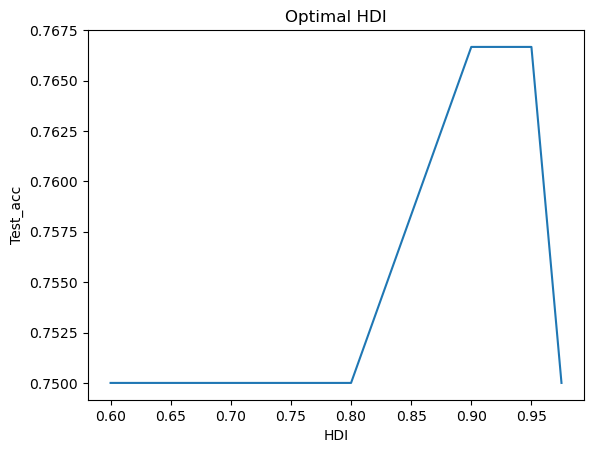

In [58]:
# plotting the points 
matplotlib.pyplot.plot(probabilities, acc)
  
# naming the x axis
matplotlib.pyplot.xlabel('HDI')
# naming the y axis
matplotlib.pyplot.ylabel('Test_acc')
  
# giving a title to my graph
matplotlib.pyplot.title('Optimal HDI')

# function to show the plot
matplotlib.pyplot.show()

##### Results using HDI=80% on the Hard Shrinkage

In [59]:
Probablity_of_the_interval=0.9

BB=az.hdi(cmdstanpy_data1.posterior,Probablity_of_the_interval)


# feature selection
keep=[]

for i in range(90):
   
    if(BB.beta[i][0]<0 and BB.beta[i][1]>0 ):
        {}
    else:
        keep.append(i)
   
   
print("\n")
print("variables to keep")
len(names[keep])



variables to keep


71

In [61]:
names[keep]

Index(['bore', 'disappoint', 'bad', 'wast', 'instead', 'easi', 'highli',
       'excel', 'lack', 'poorli', 'unfortun', 'favorit', 'skip', 'sorri',
       'stupid', 'beauti', 'suppos', 'noth', 'predict', 'import', 'step',
       'share', 'fail', 'anyth', 'appli', 'journey', 'dull', 'whatev', 'flat',
       'useless', 'wors', 'endless', 'passion', 'vagu', 'claim', 'tire',
       'whatsoev', 'soon', 'lesson', 'ridicul', 'gift', 'humor', 'half',
       'bother', 'appreci', 'fascin', 'benefit', 'devot', 'vivid', 'substanc',
       'mistak', 'superfici', 'worst', 'steel', 'decent', 'expand',
       'establish', 'premis', 'paragraph', 'X100', 'garbag', 'remark',
       'shallow', 'glad', 'unrealist', 'weak', 'fantast', 'suspect',
       'honestli', 'invit', 'extraordinari'],
      dtype='object')